In [ ]:
%matplotlib inline


# Visualizing the stock market structure


This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.


Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connection. For each
symbol, the symbols that it is connected too are those useful to explain
its fluctuations.

Clustering
----------

We use clustering to group together quotes that behave similarly. Here,
amongst the `various clustering techniques <clustering>` available
in the scikit-learn, we use `affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

Embedding in 2D space
---------------------

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use `manifold` techniques to retrieve 2D
embedding.


Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.


In [3]:
# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold


Automatically created module for IPython interactive environment


In [4]:
df = pd.read_csv('stocks/total_data_changePercent_Symbol.csv', index_col='Symbol')
df.head()

,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,...,2020-03-18,2020-03-19,2020-03-20,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-30,2020-03-31
Symbol,,,,,,,,,,,,,,,,,,,,,
A,-1.909553,-1.582437,1.309825,2.910244,-0.739096,-1.196708,-1.415933,-1.254475,-2.762439,0.627455,...,-2.279657,-4.729320,1.053261,-4.876125,5.417912,2.898551,6.402606,-3.962766,2.421900,-1.466064
AAL,-0.055677,-1.583711,-0.056598,1.211333,-3.152632,-4.921336,1.626983,-2.003646,0.000000,0.803055,...,-33.733909,-13.216712,0.867053,-1.268294,26.364943,9.551658,1.724135,-11.538461,-14.612245,-0.492210
AAP,-1.335717,-0.070351,2.103682,0.868914,-0.511536,-0.862021,-3.362382,-1.942579,-1.898390,1.319997,...,-12.970478,-3.222050,-14.580838,4.420384,9.122479,4.415188,6.950165,-1.589963,0.932644,-3.407630
AAPL,-2.898825,0.009413,1.382829,3.700062,0.107136,-2.526318,0.880059,-0.382512,-2.789743,-0.783094,...,-2.509427,-0.772122,-6.778919,-2.170527,9.117794,-0.553927,4.999225,-4.319043,2.774613,-0.204493
ABBV,-1.918017,-0.497435,3.884653,1.035039,-2.812403,-0.030409,-3.738764,0.486658,-1.287965,2.556556,...,-2.801630,0.042216,-3.254865,-6.697674,4.430283,0.618474,8.018418,-1.596262,3.415736,1.246889


In [5]:
symbols = df.index.to_numpy()
data = df.to_numpy()

In [7]:
data.shape

(485, 1319)

In [6]:
# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = data.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

C:\Users\samsung\AppData\Roaming\Python\Python37\site-packages\sklearn\covariance\_graph_lasso.py:238: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\samsung\AppData\Roaming\Python\Python37\site-packages\sklearn\covariance\_graph_lasso.py:240: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\samsung\AppData\Roaming\Python\Python37\site-packages\sklearn\covariance\_graph_lasso.py:238: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\samsung\AppData\Roaming\Python\Python37\site-packages\sklearn\covariance\_graph_lasso.py:240: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\samsung\AppData\Roaming\Python\Python37\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.803e-04
  % (max_iter, d_gap), ConvergenceWarning)


GraphicalLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
                 max_iter=100, mode='cd', n_jobs=None, n_refinements=4,
                 tol=0.0001, verbose=False)

In [9]:
# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_ )
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(symbols[labels == i])))


Cluster 1: ABBV
Cluster 2: ABMD
Cluster 3: AKAM
Cluster 4: ALGN
Cluster 5: ALXN
Cluster 6: AMCR
Cluster 7: AMD
Cluster 8: AME, APD, APH, AVY, CDW, CPRT, GLW, HON, IEX, J, LIN, MMM, NKE, ROP
Cluster 9: AMT, CCI, SBAC
Cluster 10: ANET
Cluster 11: ATVI, EA, TTWO
Cluster 12: AIV, AVB, EQR, ESS, MAA, UDR
Cluster 13: BAC, BK, C, DXC, ETFC, GS, JPM, MS, NTRS, RHI, RJF, SCHW, SIVB, STT, WFC, ZION
Cluster 14: BBY
Cluster 15: BIIB
Cluster 16: ADM, ALLE, BEN, BLK, BLL, CBRE, ECL, FDX, HPQ, IBM, IVZ, ORCL, TROW, UPS, WU
Cluster 17: BMY
Cluster 18: CAG
Cluster 19: AIZ, ALL, CB, CINF, MCD, PGR, RE, TRV, WRB
Cluster 20: CERN
Cluster 21: CHRW
Cluster 22: CHD, CLX, KMB
Cluster 23: CHTR, CMCSA, DIS
Cluster 24: CBOE, CME, ICE, NDAQ
Cluster 25: CMG
Cluster 26: AEE, AEP, ATO, AWK, CMS, D, DUK, ED, ES, EVRG, FE, LNT, NEE, NI, SO, WEC, XEL
Cluster 27: COG
Cluster 28: COST, WMT
Cluster 29: COTY
Cluster 30: CTL
Cluster 31: CTXS
Cluster 32: CVS, WBA
Cluster 33: AAL, ALK, DAL, LUV, UAL
Cluster 34: ADS, AXP, COF,

In [20]:
_

array([  4,   6,  23,  25,  29,  31,  32,  33,  36,  38,  49,  50,  57,
        59,  62,  66,  68,  74,  77,  85,  89,  94,  96,  97,  98, 100,
       104, 107, 108, 115, 117, 118, 122, 125, 126, 128, 131, 137, 138,
       140, 142, 145, 147, 153, 155, 168, 171, 173, 177, 179, 181, 186,
       191, 192, 195, 197, 201, 204, 205, 207, 209, 214, 220, 222, 228,
       230, 231, 232, 236, 238, 250, 252, 262, 266, 267, 270, 275, 276,
       279, 284, 290, 291, 298, 299, 300, 302, 303, 304, 316, 321, 322,
       325, 329, 330, 331, 336, 337, 340, 342, 344, 352, 353, 357, 363,
       368, 372, 377, 385, 387, 402, 410, 412, 414, 416, 417, 422, 423,
       425, 426, 430, 431, 433, 434, 436, 439, 440, 441, 450, 455, 461,
       463, 467, 473, 477, 480, 482], dtype=int64)

In [10]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', n_neighbors=6)
embedding = node_position_model.fit_transform(X.T).T


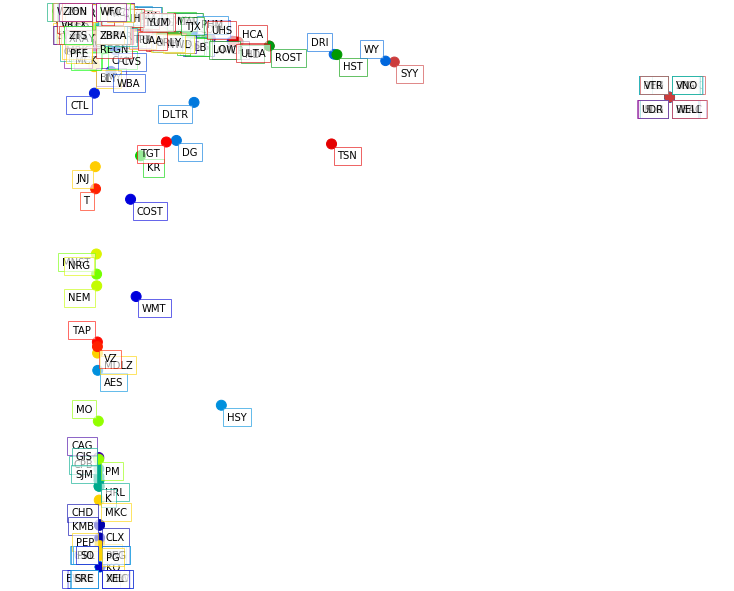

In [15]:
# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,cmap=plt.cm.nipy_spectral)

# Plot the edges
# start_idx, end_idx = np.where(non_zero)
# # a sequence of (*line0*, *line1*, *line2*), where::
# #            linen = (x0, y0), (x1, y1), ... (xm, ym)
# segments = [[embedding[:, start], embedding[:, stop]]
#            for start, stop in zip(start_idx, end_idx)]
# values = np.abs(partial_correlations[non_zero])
# lc = LineCollection(segments,
#                     zorder=0, cmap=plt.cm.hot_r,
#                     norm=plt.Normalize(0, .7 * values.max()))
# lc.set_array(values)
# lc.set_linewidths(15 * values)
# ax.add_collection(lc)


# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (symbols, label, (x, y)) in enumerate(
        zip(symbols, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, symbols, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()